# Présentation
L'entreprise TouNum travaille sur la numérisation de documents (textes, images...). Leurs services sont souvent requis par des entreprises numérisant leur base de documents papier. Ils souhaitent étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, certains de leurs clients ont une grande quantité de données à numériser, et un service de catégorisation automatique serait plus que valorisable.

L'entreprise voulant automatiser la sélection de photos pour l'annotations, le livrable 1 devra fournir une méthode de classification se basant sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos du dataset de départ. La solution pourra s'appuyer sur l'architecture de réseau de neurones de votre choix, que vous justifierez notamment du point de vue des résultats obtenus.

Plusieurs dataset sont à votre disposition. Nous avons :

- Des peintures

- Des Schéma et graphes

- Des portraits dessinés en noir et blanc

- Des images de textes scannés

- Des photos
 
Les images ne sont pas étiquetées, mais ce n'est pas un problème puisqu'elles sont réparties dans des archives différentes.

# Choix du modèle

L'architecture de réseau de neurones convolutifs (CNN) profonde est bien adaptée à notre tâche de classification d'images variées, telles que des peintures, des schémas, des portraits en noir et blanc, des textes scannés et des photos. Les CNN sont reconnus pour leur capacité à extraire des caractéristiques discriminantes des images, même en l'absence d'étiquettes.

De plus, ce modèle intègre des couches de régularisation et de dropout, contribuant à la robustesse du modèle en réduisant le risque de surapprentissage, un élément essentiel étant donné que nos données ne sont pas étiquetées. Les couches de prétraitement, notamment la normalisation et l'augmentation des données, améliorent également la capacité du modèle à généraliser face à des variations dans les images.

La fonction d'activation 'relu' et la perte SparseCategoricalCrossentropy sont des choix appropriés pour notre tâche de classification d'images, favorisant la convergence de l'apprentissage et la distinction entre les différentes catégories d'images. En somme, ce modèle représente une solution solide pour automatiser notre sélection de photos dans des données non étiquetées, répondant ainsi à nos besoins en matière de catégorisation automatique d'images.

## Import des librairies

In [9]:
!pip install pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import pickle
import tensorflow as tf
import zipfile

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/de/ce/b5d9c7ce1aaf9023b823c81932a50cd5e8f407198a696b0d1c6025a40b03/pandas-2.1.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/32/4d/aaf7eff5deb402fd9a24a1449a8119f00d74ae9c2efa79f8ef9994261fc2/pytz-2023.3.post1-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 21.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 16.5 MB/s eta 0:00:00


2023-10-11 12:47:23.514772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-11 12:47:23.514825: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-11 12:47:23.517043: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-11 12:47:23.700048: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import des données

Pour commencer, nous devons spécifier quelques paramètres pour l'apprentissage:
<ul>
    <li>La longueur et la largeur des images. </li>
    <li>La taille du batch.</li>
</ul>

In [2]:
image_h = 128
image_w = 128
batch_s = 32

## Unzip

repertoire = './'
dossier_dataset = './Dataset'
if not os.path.exists(dossier_dataset):
    os.makedirs(dossier_dataset)

for fichier in os.listdir(repertoire):
    chemin_fichier = os.path.join(repertoire,fichier)
    if zipfile.is_zipfile(chemin_fichier):
        with zipfile.ZipFile(chemin_fichier, 'r') as zip_ref:
            zip_ref.extractall(dossier_dataset)
            print(f'Fichier {fichier} décompressé dans le dossier Dataset.')
print('Tous les fichiers ZIP ont été décompressés dans le dossier Dataset')

dataset_folder = dossier_dataset
print("Début de la vérification des images avec TensorFlow...")
for subdir, _, files in os.walk(dataset_folder):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            img = tf.io.read_file(file_path)
            img = tf.image.decode_image(img)
        except Exception as e:
            print(f"Image {file_path} is invalid for TensorFlow. Exception: {e}")
            try:
                os.remove(file_path)
                print(f"Removed: {file_path}")
            except Exception as e_rm:
                print(f"Error removing {file_path}. Exception: {e_rm}")

print("Vérification des images terminée.")

## Création des dataset

In [3]:
import tensorflow as tf
dossier_dataset = './Dataset'
data_dir = dossier_dataset

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
)


Found 41398 files belonging to 5 classes.
Using 33119 files for training.


2023-10-10 14:20:52.966673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 14:20:52.970776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 14:20:52.970814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 14:20:52.971334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-10 14:20:52.971369: I tensorflow/compile

Found 41398 files belonging to 5 classes.
Using 8279 files for validation.


## Visualisation des données

In [4]:
class_names = test_set.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


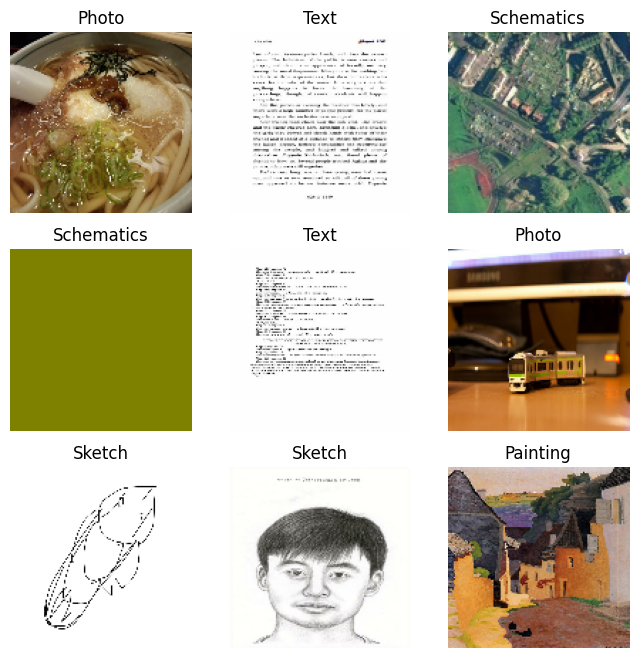

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
print(type(train_set))
images, labels = next(iter(train_set))
print(images.shape)
print(labels.shape)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
(32, 128, 128, 3)
(32,)


## Configuration de l'environnement pour l'entrainement

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [8]:
from keras.src.layers.preprocessing.image_preprocessing import HORIZONTAL_AND_VERTICAL
from keras.src.layers.preprocessing.image_preprocessing import RandomFlip
from keras.src.layers.preprocessing.image_preprocessing import RandomRotation
from keras.src.layers.preprocessing.image_preprocessing import RandomZoom
from keras import Sequential

data_augmentation = Sequential(
    [
        RandomFlip(
            mode=HORIZONTAL_AND_VERTICAL,
            input_shape=(image_h, image_w, 3)),
        RandomRotation(
            factor=0.18,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0),
        RandomZoom(
            height_factor=0.1,
            width_factor=None,
            fill_mode='reflect',
            interpolation='bilinear',
            seed=None,
            fill_value=0.0)
    ]
)

## Création du modèle

num_classes = len(class_names)
epochs = 20

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255),
    data_augmentation,
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)  # 5 dans notre cas
])
model.build((None, image_h, image_w, 3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # On utiliser un taux d'apprentissage adaptatif 

# Nouveau modèle

num_classes = len(class_names)
epochs = 50

model2 = Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_h, image_w, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model2.build((None, image_h, image_w, 3))
# Compiler le modèle avec un taux d'apprentissage adaptatif
optimizer = tf.keras.optimizers.Nadam()  # Réduisez le taux d'apprentissage
model2.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Afficher un résumé du modèle
model2.summary()

## Compilation du modèle

# Affichage des graphs

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Définir le nombre de classes et d'autres paramètres
num_classes = len(class_names)
epochs = 50

# Créer le modèle
model3 = models.Sequential()

# Couches de prétraitement
model3.add(layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(image_h, image_w, 3)))


model3.add(data_augmentation)

# Couche de convolution
model3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))

# Couche de convolution
model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))

# Couche de convolution
model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))

# Couche de convolution
model3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D((2, 2)))

# Couche entièrement connectée
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

# Couche de sortie
model3.add(Dense(num_classes, activation='softmax'))

# Compiler le modèle
optimizer = Adam(learning_rate=0.0001)
model3.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Afficher un résumé du modèle
model3.summary()


history3 = model3.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
)

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(22)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

num_classes = len(class_names) 
epochs = 50

# Utilisation de l'architecture Xception pré-entraînée
base_model = Xception(weights='imagenet', include_top=False, input_shape=(image_h, image_w, 3))
base_model.trainable = False  # Geler les couches du modèle de base

# Créer le modèle
model5 = models.Sequential([
    layers.Input(shape=(image_h, image_w, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Débloquer les dernières couches du modèle de base pour fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compiler le modèle avec un taux d'apprentissage adaptatif
optimizer = Adam(learning_rate=0.0001)
model5.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Afficher un résumé du modèle
model5.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 512)              

In [ ]:
history4 = model5.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
)

Epoch 1/50


2023-10-10 14:21:14.925211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 154 of 1000
2023-10-10 14:21:34.955061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 455 of 1000
Corrupt JPEG data: 419 extraneous bytes before marker 0xd9
2023-10-10 14:21:54.917776: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 766 of 1000
2023-10-10 14:22:10.326899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-10-10 14:22:10.427678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-10-10 14:22:11.023117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-10 14:22:14.993670: I tensorflow/compiler/xla/service/service.cc:168] XLA servic

1035/1035 [==============================] - 277s 197ms/step - loss: 1.8016 - accuracy: 0.6017 - val_loss: 1.4452 - val_accuracy: 0.7157
Epoch 2/50
1035/1035 [==============================] - 236s 228ms/step - loss: 1.5256 - accuracy: 0.6676 - val_loss: 1.3605 - val_accuracy: 0.7252
Epoch 3/50
1035/1035 [==============================] - 238s 230ms/step - loss: 1.3959 - accuracy: 0.6856 - val_loss: 1.2258 - val_accuracy: 0.7496
Epoch 4/50
1035/1035 [==============================] - 240s 232ms/step - loss: 1.2891 - accuracy: 0.7020 - val_loss: 1.1729 - val_accuracy: 0.7419
Epoch 5/50
1035/1035 [==============================] - 238s 230ms/step - loss: 1.1975 - accuracy: 0.7115 - val_loss: 1.0725 - val_accuracy: 0.7577
Epoch 6/50
1035/1035 [==============================] - 238s 230ms/step - loss: 1.1186 - accuracy: 0.7145 - val_loss: 1.0312 - val_accuracy: 0.7466
Epoch 7/50
1035/1035 [==============================] - 240s 232ms/step - loss: 1.0553 - accuracy: 0.7191 - val_loss: 0.938